In [1]:
import os
os.chdir("/home/jovyan/work/data/nasa_planet_gan/")

In [2]:
from IPython import display
import time
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
import tensorflow.keras.activations as activations
from loadfunctions import get_image_list,resize_and_load_image_list,easy_training_aug,cycle_hue_of_np_image_array

In [3]:
input_width = 128
input_height = int(input_width*.75)
input_channels = 3
num_examples_to_generate = 8
noise_dim = 64
BATCH_SIZE = 32

In [4]:
source_images_list =  get_image_list(project_dir="source_images")

resized_images = resize_and_load_image_list(source_images_list,input_width,input_height)
print(f'done resizing, shape: {resized_images.shape}')

augmented_images = easy_training_aug(resized_images,num_aug=3)
print(f'done with augmentation 1')

augmented_images_2 = cycle_hue_of_np_image_array(augmented_images)
print(f'done with augmentation 2')

print(f'number of augmented images for training: {len(augmented_images_2)}')

del source_images_list
del resized_images
del augmented_images


creating np image array
done resizing, shape: (99, 96, 128, 3)
done with augmentation 1
done with augmentation 2
number of augmented images for training: 1782


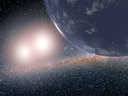

In [5]:
tf.keras.preprocessing.image.array_to_img(augmented_images_2[
    random.randint(0,len(augmented_images_2))]).show()

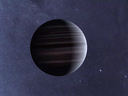

X_train: (1604, 96, 128, 3), X_test: (178, 96, 128, 3)


In [6]:
X_train = augmented_images_2
np.random.shuffle(X_train)
tf.keras.preprocessing.image.array_to_img(X_train[0]).show()

test_num = int(len(X_train)*.1)
X = X_train[0:-test_num]
X_test = X_train[-test_num:]

print(f"X_train: {X.shape}, X_test: {X_test.shape}")

In [7]:
from PIL import Image


def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False).numpy()
  print(predictions.shape,predictions.dtype)
  #fig = plt.figure(figsize=(7,2.5),dpi=160)
  fig = plt.figure()

  for i in range(predictions.shape[0]):
      plt.subplot(2, 4, i+1)
      plt.imshow((predictions[i, :, :, :] * 255).astype(np.uint8))
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  Image.fromarray((predictions[0, :, :, :] * 255).astype(np.uint8)).save('pred_1_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [20]:
# function to provide the generator of the GAN
def generator_model(output_width,output_height,output_channels):
    w8 = int(output_width/8)
    h8 = int(output_height/8)
    con_t_layers=[512,256,64,32,16,8,4,2]
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units=noise_dim,input_shape=(noise_dim,)))
    #model.add(tf.keras.layers.BatchNormalization())
    #model.add(layers.Activation(activations.tanh))

    model.add(tf.keras.layers.Dense(units=2*w8*h8))
    #model.add(tf.keras.layers.BatchNormalization())
    #model.add(layers.Activation(activations.tanh))

    model.add(tf.keras.layers.Dense(units=4*w8*h8))
    #model.add(tf.keras.layers.BatchNormalization())
    #model.add(layers.Activation(activations.tanh))

    model.add(tf.keras.layers.Dense(units=8*w8*h8))
    #model.add(tf.keras.layers.BatchNormalization())
    #model.add(layers.Activation(activations.tanh))

    model.add(tf.keras.layers.Dense(units=10*w8*h8))
    #model.add(tf.keras.layers.BatchNormalization())
    #model.add(layers.Activation(activations.tanh))

    model.add(tf.keras.layers.Reshape(target_shape=(h8,w8,10)))
    model.add(tf.keras.layers.Conv2DTranspose(filters=con_t_layers[0],kernel_size=(5,5),strides=(2,2),padding='same'))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('sigmoid'))

    model.add(tf.keras.layers.Conv2DTranspose(filters=con_t_layers[1],kernel_size=(5,5),strides=(2,2),padding='same'))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('sigmoid'))

    model.add(tf.keras.layers.Conv2DTranspose(filters=3,kernel_size=(5,5),strides=(2,2),padding='same'))
    model.add(tf.keras.layers.Activation('sigmoid'))
    return model

In [42]:
# function to provide the discriminator of the GAN
def discriminator_model():
    drop_out_list = [.5,.4,.33]
    filters_list = [8,16,32]
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=filters_list[0],kernel_size=(5,5),strides=(2,2),padding='same',input_shape=(input_height,input_width,input_channels)))
    model.add(tf.keras.layers.Dropout(drop_out_list[0]))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Conv2D(filters=filters_list[1],kernel_size=(5,5),strides=(2,2),padding='same'))
    model.add(tf.keras.layers.Dropout(drop_out_list[1]))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Conv2D(filters=filters_list[2],kernel_size=(5,5),strides=(2,2),padding='same'))
    model.add(tf.keras.layers.Dropout(drop_out_list[2]))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=1))
    model.add(tf.keras.layers.Activation('sigmoid'))
    return model

# function to provide the discriminator of the GAN
def discriminator_modelBroken():
    drop_out_list = [.5,.4,.33]
    filters_list = [8,16,32]
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=filters_list[0],kernel_size=(5,5),strides=(2,2),padding='same',input_shape=(input_height,input_width,input_channels)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=8))
    model.add(tf.keras.layers.Dense(units=4))
    model.add(tf.keras.layers.Dense(units=2))
    model.add(tf.keras.layers.Activation('tanh'))

    model.add(tf.keras.layers.Dense(units=1))
    model.add(tf.keras.layers.Activation('sigmoid'))
    return model

In [43]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [44]:

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [45]:
def generator_loss(fake_output):
    # generator wants to fool the discriminator
    # so we must define a loss function for the generator

    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [46]:
generator = generator_model(output_width=input_width,output_height=input_height,output_channels=input_channels)
print(generator.summary())


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_28 (Dense)             (None, 384)               24960     
_________________________________________________________________
dense_29 (Dense)             (None, 768)               295680    
_________________________________________________________________
dense_30 (Dense)             (None, 1536)              1181184   
_________________________________________________________________
dense_31 (Dense)             (None, 1920)              2951040   
_________________________________________________________________
reshape_3 (Reshape)          (None, 12, 16, 10)        0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 24, 32, 512)      

In [47]:
discriminator = discriminator_model()
print(discriminator.summary())

#discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=.000002,beta_1=.5)
#discriminator.compile(loss='binary_crossentropy',optimizer=discriminator_optimizer,metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 48, 64, 8)         608       
_________________________________________________________________
dropout (Dropout)            (None, 48, 64, 8)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 48, 64, 8)         32        
_________________________________________________________________
activation_23 (Activation)   (None, 48, 64, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 32, 16)        3216      
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 32, 16)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 24, 32, 16)       

In [48]:
generator_optimizer     = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


In [49]:

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return (disc_loss, gen_loss)


In [50]:

def train(dataset, epochs):
    for epoch in range(epochs):
        disc_loss_epoch_tot = 0
        gen_loss_epoch_tot = 0
        start = time.time()
        tot_batches=0

        for image_batch in dataset:
            #print(image_batch.shape)
            disc_loss, gen_loss = train_step(image_batch)
            disc_loss_epoch_tot += disc_loss
            gen_loss_epoch_tot += gen_loss
            tot_batches += 1

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        print(disc_loss_epoch_tot / tot_batches, gen_loss_epoch_tot / tot_batches)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             seed)

In [51]:
print(X_train.shape,X_test.dtype,X_train.max())

train_dataset = tf.data.Dataset.from_tensor_slices(X_train.astype("float32")/255).shuffle(BATCH_SIZE*3).batch(BATCH_SIZE)

(1782, 96, 128, 3) float64 255.0


(8, 96, 128, 3) float32


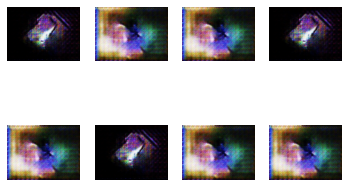

tf.Tensor(0.13111098, shape=(), dtype=float32) tf.Tensor(6.2862287, shape=(), dtype=float32)
Time for epoch 8942 is 4.035181045532227 sec


KeyboardInterrupt: 

In [52]:
train(train_dataset, 40000)